In [1]:
# -------------------------------------------------------------------------------------------------------------
# Imports
# -------------------------------------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
# -------------------------------------------------------------------------------------------------------------
# System path for imports
# -------------------------------------------------------------------------------------------------------------
PROJECT_ROOT='./'
import sys
sys.path.append(PROJECT_ROOT)

## Experiment 1: CNN + Transformer Hybrid Architecture

Contains the hybrid architecture with dot product of features

### Branch 1

In [10]:
# -------------------------------------------------------------------------------------------------------------
# Driver code
# -------------------------------------------------------------------------------------------------------------

from architecture.cnn_architecture import CNN_ARCHITECTURE
from configs.cnn_branch_config import cnn_experiment_1

model = CNN_ARCHITECTURE(cnn_experiment_1['model_args']['input_size'], cnn_experiment_1['model_args']['hidden_layers'], cnn_experiment_1['model_args']['activation'], cnn_experiment_1['model_args']['norm_layer'], cnn_experiment_1['model_args']['drop_prob'])
print(model)
model.eval()

# input_2 = torch.randn(1,3,224,224)
image = Image.open("./Blur.png").convert('RGB')
transform = transforms.Compose([transforms.ToTensor()])
input = transform(image)
print(f"Input shape: {input.shape}")

cnn_out = model(input)

print(f"Final features: {cnn_out}")
print(f"Final features shape: {cnn_out.shape}")

# features_in_shape = final_features.view(512, 28, 28)
# print(features_in_shape.shape)

CNN_ARCHITECTURE(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
  )
)
Input shape: torch.Size([3, 720, 1280])
Final features: tensor([[0.0629, 0.0603, 0.0685,  ..., 0.0205, 0.0184, 0.0126],
        [0.0086, 0.0225, 0.0224,  ..., 0.0000, 0.0000, 0.0000],
        [0.0962, 0.0855, 0.0843,  ..., 0.0395, 0.0397, 0.0375],
        ...,
        [0.0206, 0.0311, 0.0102,  ..., 0.

### Branch 2

In [11]:
from architecture.vit_architectire import VIT_ARCHITECTURE
from configs.cnn_branch_config import cnn_experiment_1

vit_model = VIT_ARCHITECTURE(cnn_experiment_1['model_args']['model_name'])


vit_out = vit_model.extract_features("./Blur.png")
print(vit_out)
print("CLS token shape:", vit_out['cls'].shape)
print("All token embeddings shape:", vit_out['all'].shape)

/opt/anaconda3/envs/HLCV/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'cls': tensor([[ 4.7615e-01, -9.9602e-02,  1.5029e+00, -5.1744e-02, -3.8278e-02,
          2.4302e+00,  4.4923e-01, -8.1642e-01, -5.7224e-01, -8.1522e-01,
         -1.8054e+00, -1.4601e-01,  3.8230e-01,  6.0427e-01, -1.1726e-01,
         -5.0949e-01, -3.7467e-01,  5.5540e-01,  1.0882e-01,  1.2580e+00,
         -6.7239e-01, -7.0905e-01, -6.4983e-01, -1.4001e+00, -7.9707e-02,
         -1.1794e+00, -5.2500e-01, -1.1217e+00,  8.0294e-01,  3.9371e-01,
         -1.1232e+00,  9.5453e-01,  6.8784e-01, -2.0632e+00,  2.1795e-01,
          3.2798e-01, -1.2843e+00,  1.1984e+00,  1.1486e+00, -4.5268e-01,
         -5.7421e-01, -1.4203e+00,  1.3407e+00,  3.2471e-01, -1.5128e+00,
         -3.7624e-01, -1.2511e+00, -1.4204e-01, -1.9368e+00,  9.1642e-01,
          5.8074e-02,  1.0683e+00, -1.2409e+00,  5.7934e-01, -9.9048e-01,
         -1.0262e+00,  5.2281e-01, -2.2733e-01,  1.8387e-01,  8.7814e-01,
          1.9188e+00, -1.4181e+00,  8.1813e-02,  6.3443e-01,  4.7809e-01,
         -1.6845e+00,  1.4446e

### Dot Product

In [12]:
# STEP 1: Remove [CLS] token
transformer_feat = vit_out["all"][:, 1:, :]   # [1, 196, 768]

# STEP 2: Reshape to [1, 768, 14, 14]
transformer_feat = transformer_feat.view(1, 14, 14, 768).permute(0, 3, 1, 2)  # [1, 768, 14, 14]

# STEP 3: Upsample to match CNN spatial size (120x120)
transformer_feat = functional.interpolate(transformer_feat, size=(120, 120), mode='bilinear', align_corners=False)  # [1, 768, 120, 120]

# STEP 4: Reshape CNN output to [1, 512, 120, 120]
cnn_feat = cnn_out.view(1, 512, 120, 120)

# STEP 5: Match channel dims (768 → 512) using 1x1 conv
conv1x1 = nn.Conv2d(768, 512, kernel_size=1)
transformer_feat_projected = conv1x1(transformer_feat)  # [1, 512, 120, 120]

# STEP 6: Element-wise multiplication (weighted attention)
fused_feat = cnn_feat * torch.sigmoid(transformer_feat_projected)

print(fused_feat)
print(f"Fused feat shape is: {fused_feat.shape}")

tensor([[[[0.0304, 0.0292, 0.0332,  ..., 0.0699, 0.0732, 0.0828],
          [0.0589, 0.0623, 0.0616,  ..., 0.0773, 0.0772, 0.0744],
          [0.0802, 0.0805, 0.0741,  ..., 0.0614, 0.0705, 0.0488],
          ...,
          [0.0501, 0.0389, 0.0336,  ..., 0.0425, 0.0520, 0.0568],
          [0.0519, 0.0567, 0.0691,  ..., 0.0674, 0.0537, 0.0545],
          [0.0641, 0.0537, 0.0687,  ..., 0.0112, 0.0101, 0.0069]],

         [[0.0040, 0.0103, 0.0103,  ..., 0.0125, 0.0354, 0.0183],
          [0.0359, 0.0223, 0.0256,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0354, 0.0315, 0.0311,  ..., 0.0612, 0.0576, 0.0594],
          [0.0757, 0.0508, 0.0477,  ..., 0.0830, 0.0758, 0.0760],
          [0.0706, 0.0792, 0.0621,  ..., 0

In [13]:
from architecture.reconstruction_head import RECONSTRUCTION_HEAD

recon_head = RECONSTRUCTION_HEAD(512, 3)

output_image = recon_head(fused_feat)

image_tensor = output_image.squeeze(0)
print(f"image_tensor: {image_tensor.shape}")

image_tensor = (image_tensor + 1)/2.0
img_tensor = image_tensor.clamp(0, 1)

# Step 3: Convert to numpy and reshape
img_np = img_tensor.mul(255).byte().permute(1, 2, 0).cpu().numpy()  # [120, 120, 3]
print(img_np)

# Step 4: Convert to PIL Image and show
img_pil = Image.fromarray(img_np)
img_pil.show()

image_tensor: torch.Size([3, 120, 120])
[[[123 130 126]
  [123 130 126]
  [123 130 126]
  ...
  [123 130 126]
  [123 130 126]
  [123 130 125]]

 [[123 130 126]
  [123 130 126]
  [123 130 126]
  ...
  [123 130 126]
  [123 130 126]
  [123 129 126]]

 [[123 130 126]
  [123 130 126]
  [123 130 126]
  ...
  [123 130 126]
  [123 130 126]
  [123 129 126]]

 ...

 [[123 130 126]
  [123 130 126]
  [123 130 126]
  ...
  [123 130 126]
  [123 130 126]
  [123 129 126]]

 [[123 130 126]
  [123 130 126]
  [123 130 126]
  ...
  [123 130 126]
  [123 130 126]
  [122 130 126]]

 [[123 130 126]
  [123 129 126]
  [123 129 126]
  ...
  [123 129 126]
  [123 129 126]
  [123 129 126]]]


### CNN-ViT Hybrid Model

/opt/anaconda3/envs/HLCV/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


torch.Size([3, 224, 224])
vit_attention_map.shape: torch.Size([1, 197, 197])


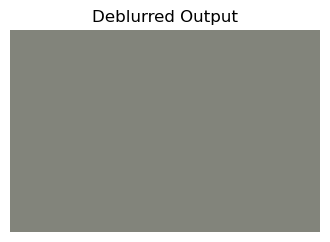

tensor([[[[ 0.0270,  0.0265,  0.0258,  ...,  0.0261,  0.0260,  0.0257],
          [ 0.0257,  0.0261,  0.0252,  ...,  0.0255,  0.0256,  0.0270],
          [ 0.0250,  0.0254,  0.0245,  ...,  0.0249,  0.0251,  0.0270],
          ...,
          [ 0.0249,  0.0253,  0.0245,  ...,  0.0249,  0.0250,  0.0270],
          [ 0.0252,  0.0253,  0.0246,  ...,  0.0250,  0.0254,  0.0270],
          [ 0.0258,  0.0246,  0.0243,  ...,  0.0246,  0.0251,  0.0281]],

         [[ 0.0375,  0.0394,  0.0385,  ...,  0.0387,  0.0397,  0.0404],
          [ 0.0382,  0.0391,  0.0384,  ...,  0.0384,  0.0404,  0.0417],
          [ 0.0373,  0.0382,  0.0376,  ...,  0.0377,  0.0396,  0.0415],
          ...,
          [ 0.0372,  0.0380,  0.0373,  ...,  0.0375,  0.0394,  0.0414],
          [ 0.0385,  0.0391,  0.0383,  ...,  0.0385,  0.0398,  0.0416],
          [ 0.0379,  0.0391,  0.0388,  ...,  0.0387,  0.0398,  0.0389]],

         [[-0.0303, -0.0317, -0.0312,  ..., -0.0310, -0.0320, -0.0293],
          [-0.0310, -0.0314, -

In [3]:
from architecture.cnn_vit_hybrid_architecture import CNN_VIT_HYBRID_ARCHITECTURE

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
raw_image = Image.open("./Blur.png").convert('RGB')
image = transform(raw_image)


model = CNN_VIT_HYBRID_ARCHITECTURE()
model(image)


